## 특정 영역(독도 반경 50km)의 생물종 증감률 분석     
2018년 말을 기준으로 이전 3년(2016~2018)과 이후 3년(2019~2021)간의     
수온 및 생물종 증감률 분석을 통해 변화 특성을 찾기  

### 필요한 패키지(모듈/라이브러리) 준비

In [1]:
import os
import pandas as pd  #2차원 표 형태의 데이터프레임 처리용 패키지
import geopandas as gpd  #pandas를 기반으로 벡터 지오메트리(점/선/면)를 포함한 GeoDataFrame을 처리하는 패키지
from shapely.geometry import Point, Polygon #점, 선, 면 Geometry 처리용 패키지 
pd.set_option('float_format', '{:f}'.format)  # 숫자가 지수 형태로 표시되지 않도록 

c:\Users\leesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# pip install xarray netcdf4 h5netcdf
import numpy as np   #배열 등의 수치 데이터 처리용 패키지 
import xarray as xr  #netcdf와 같은 다차원 배열 데이터 처리용 패키지

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px #차트 시각화 패키지 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid') #whitegrid, dark, white, ticks
mpl.rc('font', family='Malgun Gothic') #한글 폰트 적용시
plt.rcParams["figure.figsize"] = (10, 10) #차트 사이즈

### 수온 변화 검토   
EU Copernicus에서 제공하는 월별 해양 관측 데이터를 활용   
netcdf라는 시공간 다차원 데이터에 수온, 염분 등의 정보가 담겨있음    
https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=MULTIOBS_GLO_PHY_TSUV_3D_MYNRT_015_012  


In [4]:
ds201601 = xr.open_dataset('../data/copernicus/before/dataset-armor-3d-rep-monthly_20160115T1200Z_P20201106T2204Z.nc')  
ds201601

<xarray.Dataset>
Dimensions:    (time: 1, depth: 50, latitude: 689, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-16
  * depth      (depth) int16 0 5 10 15 20 25 ... 3000 3500 4000 4500 5000 5500
  * latitude   (latitude) float32 -82.12 -81.88 -81.62 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    so         (time, depth, latitude, longitude) float32 ...
    to         (time, depth, latitude, longitude) float32 ...
    ugo        (time, depth, latitude, longitude) float32 ...
    vgo        (time, depth, latitude, longitude) float32 ...
    zo         (time, depth, latitude, longitude) float32 ...
    mlotst     (time, latitude, longitude) float32 ...
Attributes:
    description:  ARMOR3D REP CMEMS December 2020 Release
    Conventions:  CF-1.0
    institution:  CLS
    domain_name:  GLO
    history:      2016-01-15 12:00:00 ARMOR3D REP - TSHUV Global Ocean Observ...
    title:        ARMOR3D REP - TSHUVMld Global Ocean Observation-based Produ...

In [35]:
# 독도 주변  경도와 위도 범위 설정
lon_min, lon_max = 130, 133  # 경도 범위
lat_min, lat_max = 36, 39  # 위도 범위

In [36]:
# 기준 시점 이전 3년의 데이터 로딩
# 폴더 경로 설정
folder_path = '../data/copernicus/before'
df = {}

# 해당 폴더 내의 모든 파일을 읽어서 전처리 진행
for idx, filename in enumerate(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, filename)
    # 데이터 로딩
    ds = xr.open_dataset(file_path)
    # dataset에서 좌표 범위 데이터를 추출
    ds = ds.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))
    # Pandas DataFrame으로 변환 
    df[str(idx)] = ds.to_dataframe().reset_index()
    # 표층(depth = 0) 데이터만 추출
    df[str(idx)] = df[str(idx)][ df[str(idx)]['depth'] == 0   ]    
    # print(str(idx))


In [37]:
# 기준 시점 이전 3년치 데이터를 병합 

# df 딕셔너리에 저장된 DataFrame들을 리스트에 모으기
dataframes = [df[str(i)] for i in range(8)]

# pandas.concat()을 사용하여 모든 DataFrame 병합
df_before = pd.concat(dataframes, ignore_index=True)

In [8]:
# 기준 시점 이전 3년치 데이터 좌표(격자)별 평균 수온을 산출
df_before2 = df_before.groupby(['latitude', 'longitude'])['to'].mean().reset_index()
df_before2.info()
df_before2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   144 non-null    float32
 1   longitude  144 non-null    float32
 2   to         144 non-null    float32
dtypes: float32(3)
memory usage: 1.8 KB


,latitude,longitude,to
0,36.125000,130.125000,13.005375
1,36.125000,130.375000,12.741250
2,36.125000,130.625000,12.479124
3,36.125000,130.875000,12.191250
4,36.125000,131.125000,11.939000


In [9]:
# 0.25도 간격의 격자 폴리곤 생성 함수
def create_polygon(lat, lon):
    return Polygon([(lon, lat),
                    (lon + 0.25, lat),
                    (lon + 0.25, lat + 0.25),
                    (lon, lat + 0.25)])

In [10]:
# 각 좌표에 대한 폴리곤 생성
geom = df_before2.apply(lambda row: create_polygon(row['latitude'], row['longitude']), axis=1)
# DataFrame을 GeoDataFrame으로 변환
gdf_before = gpd.GeoDataFrame(df_before2, geometry=geom, crs='4326')

In [11]:
# GeoDataFrame 기초정보 확인 
gdf_before.info()
gdf_before.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   latitude   144 non-null    float32 
 1   longitude  144 non-null    float32 
 2   to         144 non-null    float32 
 3   geometry   144 non-null    geometry
dtypes: float32(3), geometry(1)
memory usage: 2.9 KB


,latitude,longitude,to,geometry
0,36.125000,130.125000,13.005375,"POLYGON ((130.12500 36.12500, 130.37500 36.125..."
1,36.125000,130.375000,12.741250,"POLYGON ((130.37500 36.12500, 130.62500 36.125..."
2,36.125000,130.625000,12.479124,"POLYGON ((130.62500 36.12500, 130.87500 36.125..."
3,36.125000,130.875000,12.191250,"POLYGON ((130.87500 36.12500, 131.12500 36.125..."
4,36.125000,131.125000,11.939000,"POLYGON ((131.12500 36.12500, 131.37500 36.125..."


In [12]:
gdf_before.explore('to')

c:\Users\leesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\explore.py:400: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(gdf[column]):


## 기준 시점 이후 3년치의 데이터들을 가공하여 격자별 평균 수온을 산출

In [13]:
# 기준 시점 이후 3년의 여름철 데이터 로딩
# 폴더 경로 설정
folder_path = '../data/copernicus/after'
df = {}

# 해당 폴더 내의 모든 파일을 읽어서 전처리 진행
for idx, filename in enumerate(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, filename)
    # 데이터 로딩
    ds = xr.open_dataset(file_path)
    # dataset에서 좌표 범위 데이터를 추출
    ds = ds.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))
    # Pandas DataFrame으로 변환 
    df[str(idx)] = ds.to_dataframe().reset_index()
    # 표층(depth = 0) 데이터만 추출
    df[str(idx)] = df[str(idx)][ df[str(idx)]['depth'] == 0   ]    
    # print(str(idx))

In [14]:
# 기준 시점 이후 3년치 데이터를 병합 

# df 딕셔너리에 저장된 DataFrame들을 리스트에 모으기
dataframes = [df[str(i)] for i in range(8)]

# pandas.concat()을 사용하여 모든 DataFrame 병합
df_after = pd.concat(dataframes, ignore_index=True)	

In [15]:
# 기준 시점 이후 3년치 데이터 좌표(격자)별 평균 수온을 산출
df_after2 = df_after.groupby(['latitude', 'longitude'])['to'].mean().reset_index()
df_after2.info()
df_after2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   144 non-null    float32
 1   longitude  144 non-null    float32
 2   to         144 non-null    float32
dtypes: float32(3)
memory usage: 1.8 KB


,latitude,longitude,to
0,36.125000,130.125000,13.524750
1,36.125000,130.375000,13.436749
2,36.125000,130.625000,13.457375
3,36.125000,130.875000,13.299874
4,36.125000,131.125000,13.116000


In [16]:
# 각 좌표에 대한 폴리곤 생성
geom = df_after2.apply(lambda row: create_polygon(row['latitude'], row['longitude']), axis=1)
# DataFrame을 GeoDataFrame으로 변환
gdf_after = gpd.GeoDataFrame(df_after2, geometry=geom, crs='4326')

In [17]:
gdf_after.explore('to')

c:\Users\leesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\explore.py:400: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(gdf[column]):


#### 공간 영역 설정

https://www.openstreetmap.org/ 에 접속해서 '독도'를 검색하고, 울릉군 독도리에 해당하는 독도를 클릭하면 해당 위치로 지도가 표시됨     
지도의 독도 상에서 컨텍스트 메뉴의 "여기를 가운데로 지정"를 선택하면, 독도에 대한 좌표가 URL에 보임     
https://www.openstreetmap.org/relation/6646538#map=16/37.2422/131.8669   

또는 epsg.io.map에 접속해도 쉽게 좌표를 확인할 수 있음    
https://epsg.io/map#srs=4326&x=131.866279&y=37.241672&z=15&layer=streets   
131.866279 37.241672

In [18]:
# 특정 위도, 경도 및 버퍼 거리를 설정합니다.
longitude = 131.866279
latitude = 37.241672
buffer_distance = 50000   #50킬로미터  
geom_latlon = Point(longitude, latitude)                # 경위도 Point Geometry를 생성
gdf_pt4326 = gpd.GeoDataFrame(geometry=[geom_latlon], crs='epsg:4326' ) # 경위도 Point GeoDataFrame을 생성
gdf_pt3857 = gdf_pt4326.to_crs(epsg=3857)               # Point GeoDataFrame을 평면직각좌표계(3857)로 변환
geom_buf = gdf_pt3857.geometry.buffer(buffer_distance)  # gdf_pt3857에 대한 버퍼 공간데이터를 생성 
gdf_buf3857 = gpd.GeoDataFrame(geometry=geom_buf )      # 버퍼 폴리곤을 GeoDataFrame으로 변환
gdf_buf4326 = gdf_buf3857.to_crs(epsg=4326)             # 버퍼 폴리곤을 4326으로 변환 (생물종과 공간조인을 위해)

In [19]:
gdf_buf4326.explore()

In [20]:
# 위도-경도를 이용한 고유ID 부여
gdf_before['lat_lon'] = gdf_before['latitude'].astype(str) + '_' + gdf_before['longitude'].astype(str)
# 이전 데이터에서 독도 반경 영역에 해당하는 데이터만 추출 
gdf_before2 = gpd.sjoin(gdf_before, gdf_buf4326, how='inner', predicate='intersects', lsuffix='left' ).reset_index()
gdf_before2.info()
gdf_before2.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   index        12 non-null     int64   
 1   latitude     12 non-null     float32 
 2   longitude    12 non-null     float32 
 3   to           12 non-null     float32 
 4   geometry     12 non-null     geometry
 5   lat_lon      12 non-null     object  
 6   index_right  12 non-null     int64   
dtypes: float32(3), geometry(1), int64(2), object(1)
memory usage: 660.0+ bytes


,index,latitude,longitude,to,geometry,lat_lon,index_right
0,41,36.875000,131.375000,11.798624,"POLYGON ((131.37500 36.87500, 131.62500 36.875...",36.875_131.375,0
1,42,36.875000,131.625000,11.864250,"POLYGON ((131.62500 36.87500, 131.87500 36.875...",36.875_131.625,0
2,43,36.875000,131.875000,11.808374,"POLYGON ((131.87500 36.87500, 132.12500 36.875...",36.875_131.875,0
3,44,36.875000,132.125000,11.551374,"POLYGON ((132.12500 36.87500, 132.37500 36.875...",36.875_132.125,0
4,53,37.125000,131.375000,11.797874,"POLYGON ((131.37500 37.12500, 131.62500 37.125...",37.125_131.375,0


In [21]:
gdf_before2.explore('to')

c:\Users\leesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\explore.py:400: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(gdf[column]):


In [22]:
# 위도-경도를 이용한 고유ID 부여
gdf_after['lat_lon'] = gdf_after['latitude'].astype(str) + '_' + gdf_after['longitude'].astype(str)
# 이전 데이터에서 독도 반경 영역에 해당하는 데이터만 추출 
gdf_after2 = gpd.sjoin(gdf_after, gdf_buf4326, how='inner', predicate='intersects', lsuffix='left' ).reset_index()

In [23]:
gdf_after2.explore('to')

c:\Users\leesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\explore.py:400: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(gdf[column]):


증감률 = [(기준시점 이후의 측정값 - 기준시점 이전의 측정값) ÷ 기준시점 이전의 측정값] × 100    
증감률이 100이면 2배 증가한 것 

In [24]:
# lat_lon 값을 기준으로 이전과 이후 데이터 병합
merged_df = gdf_before2.merge(gdf_after2, on='lat_lon', suffixes=('_b', '_a'))

In [25]:
merged_df.head()

,index_b,latitude_b,longitude_b,to_b,geometry_b,lat_lon,index_right_b,index_a,latitude_a,longitude_a,to_a,geometry_a,index_right_a
0,41,36.875000,131.375000,11.798624,"POLYGON ((131.37500 36.87500, 131.62500 36.875...",36.875_131.375,0,41,36.875000,131.375000,12.331250,"POLYGON ((131.37500 36.87500, 131.62500 36.875...",0
1,42,36.875000,131.625000,11.864250,"POLYGON ((131.62500 36.87500, 131.87500 36.875...",36.875_131.625,0,42,36.875000,131.625000,12.436749,"POLYGON ((131.62500 36.87500, 131.87500 36.875...",0
2,43,36.875000,131.875000,11.808374,"POLYGON ((131.87500 36.87500, 132.12500 36.875...",36.875_131.875,0,43,36.875000,131.875000,12.379499,"POLYGON ((131.87500 36.87500, 132.12500 36.875...",0
3,44,36.875000,132.125000,11.551374,"POLYGON ((132.12500 36.87500, 132.37500 36.875...",36.875_132.125,0,44,36.875000,132.125000,12.391624,"POLYGON ((132.12500 36.87500, 132.37500 36.875...",0
4,53,37.125000,131.375000,11.797874,"POLYGON ((131.37500 37.12500, 131.62500 37.125...",37.125_131.375,0,53,37.125000,131.375000,12.276125,"POLYGON ((131.37500 37.12500, 131.62500 37.125...",0


In [26]:
# 증감률 계산: [(이후 데이터의 값 - 이전 데이터의 값) / 이전 데이터의 값] * 100
merged_df['growth_rate'] = ((merged_df['to_a'] - merged_df['to_b']) / merged_df['to_b']) * 100
print(merged_df[['lat_lon', 'growth_rate']])

           lat_lon  growth_rate
0   36.875_131.375     4.514307
1   36.875_131.625     4.825415
2   36.875_131.875     4.836610
3   36.875_132.125     7.274026
4   37.125_131.375     4.053701
5   37.125_131.625     2.336437
6   37.125_131.875     1.334160
7   37.125_132.125     5.205496
8   37.375_131.375     5.051651
9   37.375_131.625     3.266130
10  37.375_131.875     3.074442
11  37.375_132.125     6.614692


In [27]:
# 증감률을 내림차순으로 정렬
merged_df2 = merged_df.sort_values(by='growth_rate', ascending=False)
merged_df2.head()

,index_b,latitude_b,longitude_b,to_b,geometry_b,lat_lon,index_right_b,index_a,latitude_a,longitude_a,to_a,geometry_a,index_right_a,growth_rate
3,44,36.875000,132.125000,11.551374,"POLYGON ((132.12500 36.87500, 132.37500 36.875...",36.875_132.125,0,44,36.875000,132.125000,12.391624,"POLYGON ((132.12500 36.87500, 132.37500 36.875...",0,7.274026
11,68,37.375000,132.125000,11.593500,"POLYGON ((132.12500 37.37500, 132.37500 37.375...",37.375_132.125,0,68,37.375000,132.125000,12.360374,"POLYGON ((132.12500 37.37500, 132.37500 37.375...",0,6.614692
7,56,37.125000,132.125000,11.831249,"POLYGON ((132.12500 37.12500, 132.37500 37.125...",37.125_132.125,0,56,37.125000,132.125000,12.447124,"POLYGON ((132.12500 37.12500, 132.37500 37.125...",0,5.205496
8,65,37.375000,131.375000,11.580375,"POLYGON ((131.37500 37.37500, 131.62500 37.375...",37.375_131.375,0,65,37.375000,131.375000,12.165375,"POLYGON ((131.37500 37.37500, 131.62500 37.375...",0,5.051651
2,43,36.875000,131.875000,11.808374,"POLYGON ((131.87500 36.87500, 132.12500 36.875...",36.875_131.875,0,43,36.875000,131.875000,12.379499,"POLYGON ((131.87500 36.87500, 132.12500 36.875...",0,4.836610


In [28]:
# Plotly 막대 차트를 그립니다
fig = px.bar(merged_df2, x='lat_lon', y='growth_rate', title='2016~2018년과 2019~2021년의 1~3월 평균 수온 증감률')

# x축과 y축의 제목을 설정합니다.
fig.update_layout(
    xaxis_title="격자(위도_경도)",
    yaxis_title="증감률",
)

fig.show()

### 지도 시각화

In [29]:
# 증감률 데이터에서 필요한 항목만 추출
merged_df3 = merged_df2[['lat_lon', 'growth_rate']]

In [30]:
# 공간(격자)데이터와 증감률 데이터를 속성조인
gdf_growth = pd.merge(gdf_after2, merged_df3, on='lat_lon', how='inner')

In [31]:
# 증감률을 지도시각화 
gdf_growth.explore('growth_rate', cmap='RdBu_r', tiles='http://xdworld.vworld.kr:8080/2d/gray/service/{z}/{x}/{y}.png', attr='브이월드')

c:\Users\leesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\explore.py:400: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



#### 이전과 이후를 동일한 기준 범위의 단계구분도로 시각화하여 비교해 보기   

In [32]:
# 두 데이터 세트의 최소값과 최대값 찾기
vmin = min(gdf_before2['to'].min(), gdf_after2['to'].min())
vmax = max(gdf_before2['to'].max(), gdf_after2['to'].max())

In [33]:
vmin, vmax

(11.551374, 12.480124)

In [39]:
# pip install contextily
import contextily as ctx

In [40]:
gdf_b3857 = gdf_before2.to_crs(3857)
gdf_a3857 = gdf_after2.to_crs(3857)

c:\Users\leesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:732: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



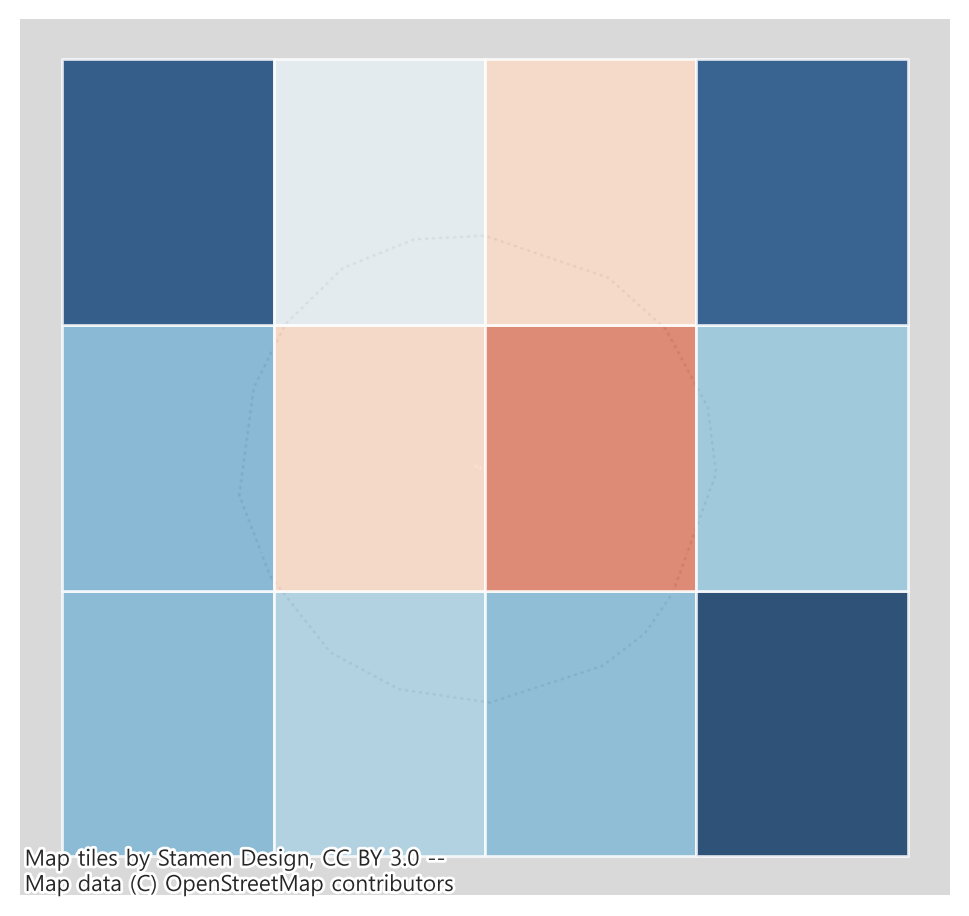

In [41]:
ax = gdf_b3857.plot(column='to', k=5, cmap='RdBu_r', figsize=(6, 6), alpha=0.8, vmin=vmin, vmax=vmax)   
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)    # 'http://xdworld.vworld.kr:8080/2d/gray/service/{z}/{x}/{y}.png'
ax.set_axis_off()
plt.show()

c:\Users\leesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:732: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



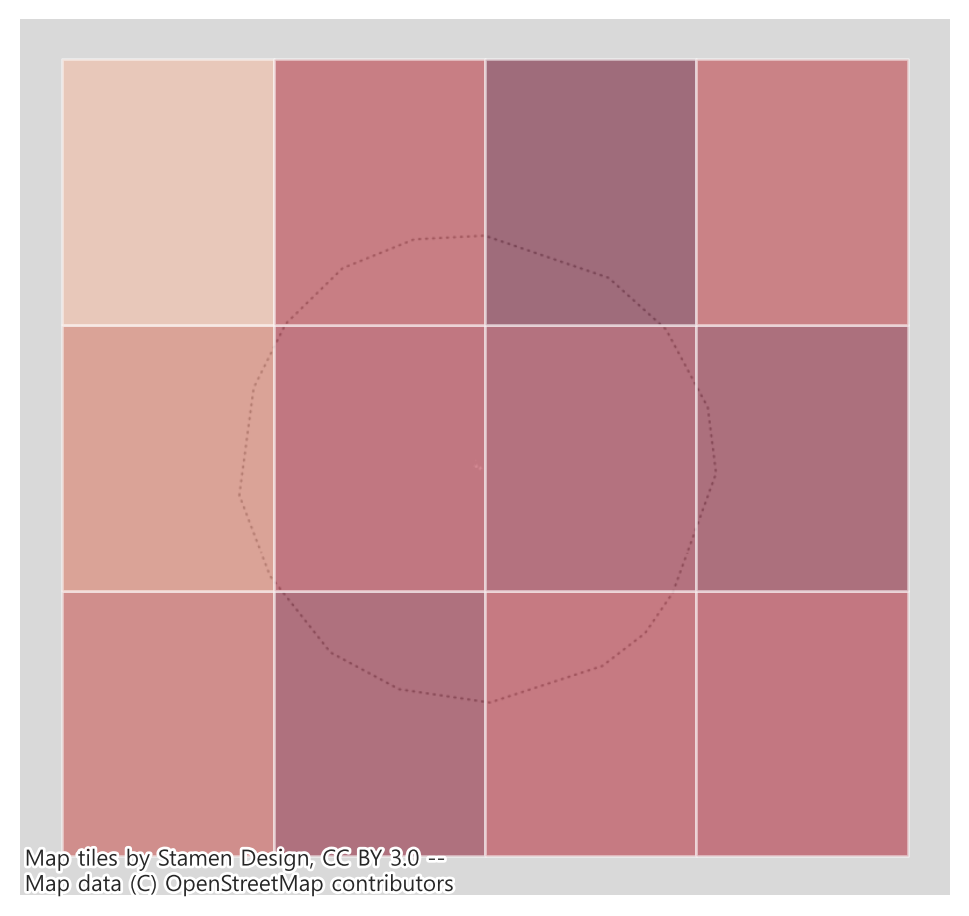

In [43]:
ax = gdf_a3857.plot(column='to', k=5, cmap='RdBu_r', figsize=(6, 6), alpha=0.5, vmin=vmin, vmax=vmax)   
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)  
ax.set_axis_off()
plt.show()